In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
import joblib

import datetime

In [40]:
# Train
size = 'demo'
type_ = 'train'

X_train_file_path = f'./files/numpy/X_{type_}_{size}.npy'
y_train_file_path = f'./files/numpy/y_{type_}_{size}.npy'

X_train = np.load(X_train_file_path)
y_train = np.load(y_train_file_path)

# Validation 
size = 'demo'
type_ = 'validation'

X_val_file_path = f'./files/numpy/X_{type_}_{size}.npy'
y_val_file_path = f'./files/numpy/y_{type_}_{size}.npy'

X_val = np.load(X_val_file_path)
y_val = np.load(y_val_file_path)


print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(24189, 900)
(24706, 900)
(24189,)
(24706,)


In [41]:
X_train[0]

array([-7.09240714e-02, -2.17348675e-01, -2.36625010e-01,  1.00848418e-01,
       -1.98876939e-02, -1.48839681e-01,  2.32077540e-01,  3.53403061e-01,
       -4.03793146e-02,  4.47423088e-02,  2.40427028e-01, -3.83496754e-03,
       -2.89386241e-01, -3.05737755e-01, -2.62293898e-01,  5.39218655e-02,
        3.35099706e-01, -4.78517228e-02,  2.36782136e-01,  4.19471436e-02,
       -2.21418816e-02, -5.18543634e-02, -2.39778999e-01,  5.30597037e-02,
        1.19511494e-02, -1.09297100e-01,  3.36618481e-01, -1.29487421e-01,
       -3.33948369e-02, -1.53427237e-01,  9.89886319e-02, -2.28751020e-01,
       -1.88883911e-03,  2.82506765e-02, -2.56629494e-01,  1.16042365e-03,
        4.74690587e-02, -7.41290805e-02,  7.03323118e-03,  9.14100130e-02,
        7.28310353e-02,  2.72587444e-02, -8.88386266e-03, -1.06551956e-01,
       -7.47184218e-02, -1.63811127e-01, -7.86825225e-02,  1.58220787e-01,
       -9.91037487e-02,  1.91956682e-01,  1.12046985e-01, -3.69802330e-02,
        1.31926066e-01, -

In [42]:
y_train[0:10]

array([ 13., 108.,  12.,   4.,  11.,  51.,   9.,  21.,  11.,   6.])

In [45]:
# # Normalize the input data
# scaler_X = StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_val = scaler_X.transform(X_val)

# # Normalize the target data
# scaler_y = MinMaxScaler()
# y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
# y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

In [53]:
# # Save the scalers
# joblib.dump(scaler_X, './files/models/scaler_X.pkl')
# joblib.dump(scaler_y, './files/models/scaler_y.pkl')

['./files/models/scaler_y.pkl']

In [46]:
X_train[0]

array([-1.51089262e-01, -3.56178374e-01, -4.04072406e-01,  2.09165476e-01,
       -4.29506316e-02, -2.22536366e-01,  3.96342311e-01,  5.99277824e-01,
       -7.78336614e-02,  8.64230989e-02,  3.41730441e-01, -4.17940999e-03,
       -5.37474335e-01, -5.52694678e-01, -4.89871510e-01,  1.13185936e-01,
        6.28230832e-01, -7.76380199e-02,  4.14833295e-01,  6.29003609e-02,
       -5.72137412e-02, -1.09886388e-01, -3.61528296e-01,  7.58984775e-02,
        1.79276709e-02, -1.66728083e-01,  5.54504182e-01, -2.27913885e-01,
       -3.39589725e-02, -2.42680765e-01,  1.62037135e-01, -3.53538790e-01,
        1.52727942e-02,  2.34567961e-02, -3.90091553e-01, -6.19457903e-04,
        3.04287068e-02, -1.29973406e-01, -1.89366763e-02,  2.02294811e-01,
        7.80362371e-02,  3.11923077e-02, -3.32311742e-03, -1.39684960e-01,
       -1.34527380e-01, -2.67338021e-01, -8.04671123e-02,  2.29299321e-01,
       -2.00945908e-01,  2.91368944e-01,  1.49499152e-01, -8.89290351e-02,
        1.55713731e-01, -

In [48]:
y_train[0:10]

array([0.02006689, 0.17892977, 0.01839465, 0.00501672, 0.01672241,
       0.08361204, 0.01337793, 0.03344482, 0.01672241, 0.0083612 ])

In [6]:
# model = Sequential([
#     tf.keras.Input(shape=(X_val.shape[1],)),
#     Dense(256, activation='relu'),
#     Dropout(0.2),  # Adding Dropout layer after the first Dense layer
#     Dense(128, activation='relu'),
#     Dropout(0.2),  # Adding Dropout layer after the second Dense layer
#     Dense(32, activation='relu'),
#     Dropout(0.2),  # Adding Dropout layer after the third Dense layer
#     Dense(1, activation='linear')
# ])

# # Define the optimizer with a specific learning rate
# learning_rate = 1e-4
# clipnorm=1.0
# optimizer = Adam(learning_rate=learning_rate,clipnorm =clipnorm)

# # Compile the model
# model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae', 'accuracy']) 

# # Summary of the model
# model.summary()

In [49]:
# Define the model
model = Sequential([
    tf.keras.Input(shape=(X_val.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.2),  # Adding Dropout layer after the first Dense layer
    Dense(128, activation='relu'),
    Dropout(0.2),  # Adding Dropout layer after the second Dense layer
    Dense(32, activation='relu'),
    Dropout(0.2),  # Adding Dropout layer after the third Dense layer
    Dense(1, activation='linear')
])
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=2, min_lr=0.005)
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae', 'mape'])


In [50]:
# Prepare TensorBoard callback
log_dir = "files/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
num_epochs = 50
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=16,
                    validation_data=(X_val, y_val),
                    
                    callbacks=[tensorboard_callback, TqdmCallback(verbose=1),early_stop], #, reduce_lr
                    verbose=2)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50
1512/1512 - 16s - loss: 0.0192 - mse: 0.0192 - mae: 0.0724 - mape: 13642.7393 - val_loss: 0.1430 - val_mse: 0.1430 - val_mae: 0.3469 - val_mape: 135977.3594 - 16s/epoch - 11ms/step
Epoch 2/50
1512/1512 - 14s - loss: 0.0087 - mse: 0.0087 - mae: 0.0553 - mape: 15505.0576 - val_loss: 0.1114 - val_mse: 0.1114 - val_mae: 0.2483 - val_mape: 134432.1562 - 14s/epoch - 9ms/step
Epoch 3/50
1512/1512 - 14s - loss: 0.0087 - mse: 0.0087 - mae: 0.0538 - mape: 14206.8076 - val_loss: 0.0544 - val_mse: 0.0544 - val_mae: 0.1676 - val_mape: 138234.5312 - 14s/epoch - 9ms/step
Epoch 4/50
1512/1512 - 14s - loss: 0.0082 - mse: 0.0082 - mae: 0.0533 - mape: 15392.7314 - val_loss: 0.0575 - val_mse: 0.0575 - val_mae: 0.1551 - val_mape: 54251.0078 - 14s/epoch - 9ms/step
Epoch 5/50
1512/1512 - 15s - loss: 0.0081 - mse: 0.0081 - mae: 0.0527 - mape: 15380.7607 - val_loss: 0.0707 - val_mse: 0.0707 - val_mae: 0.1383 - val_mape: 70757.4688 - 15s/epoch - 10ms/step
Epoch 6/50
1512/1512 - 16s - loss: 0.0079 - m

In [9]:
pd.DataFrame(history.history)

,loss,mse,mae,mape,val_loss,val_mse,val_mae,val_mape
0,2934.780518,2934.780518,30.717480,147.283691,3139.165771,3139.165771,31.482279,146.270126
1,2650.210449,2650.210449,29.140751,137.687408,3207.778564,3207.778564,32.741852,157.275085
2,2494.208008,2494.208008,28.463850,133.199112,3806.425049,3806.425049,37.799404,205.726196
3,2304.532227,2304.532227,27.451036,127.439018,4538.567383,4538.567383,39.658916,218.564178
4,1990.670654,1990.670654,25.845505,121.864227,6405.855957,6405.855957,41.867542,225.586380
5,1666.785400,1666.785400,24.095089,113.152695,12857.298828,12857.298828,49.532486,277.347839
6,1378.935913,1378.935913,22.314320,105.252708,16869.302734,16869.302734,51.188198,283.988861
7,1210.184937,1210.184937,21.248569,99.828995,22585.273438,22585.273438,56.725750,325.258514
8,1104.204834,1104.204834,20.486355,96.811249,26185.441406,26185.441406,57.713455,328.542084
9,1047.722412,1047.722412,19.891125,93.411003,24709.419922,24709.419922,57.241253,329.715790


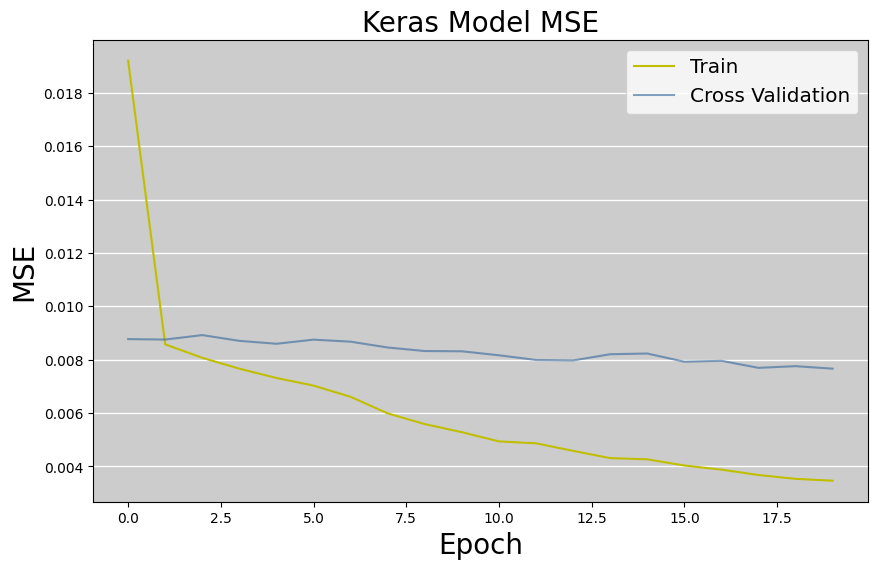

In [29]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mse'], color='y')
plt.plot(history.history['val_mse'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Keras Model MSE',size=20)
plt.ylabel('MSE',size=20)
plt.xlabel('Epoch',size=20)
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
plt.gca().patch.set_facecolor('0.8')
plt.legend(['Train', 'Cross Validation'],fontsize='x-large', loc='upper right')
plt.show()

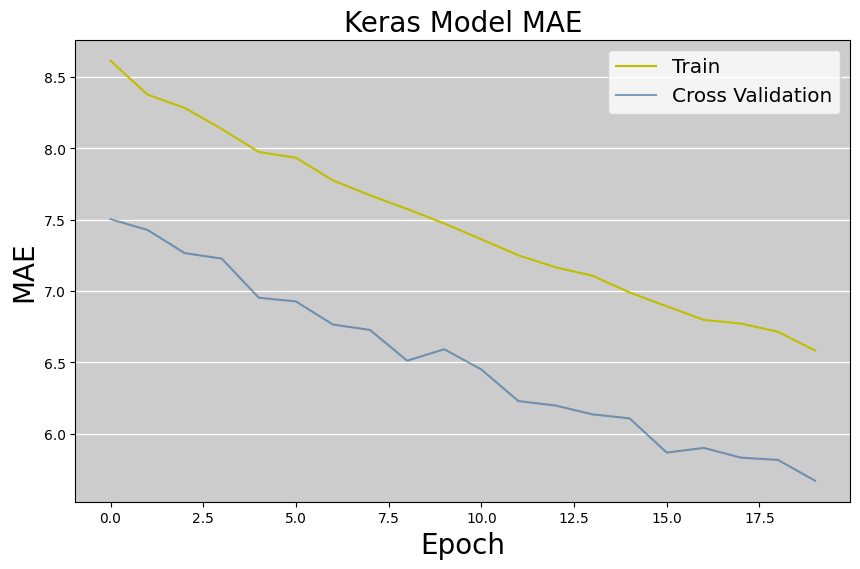

In [34]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mae'], color='y')
plt.plot(history.history['val_mae'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Keras Model MAE',size=20)
plt.ylabel('MAE',size=20)
plt.xlabel('Epoch',size=20)
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
plt.gca().patch.set_facecolor('0.8')
plt.legend(['Train', 'Cross Validation'],fontsize='x-large', loc='upper right')
plt.show()

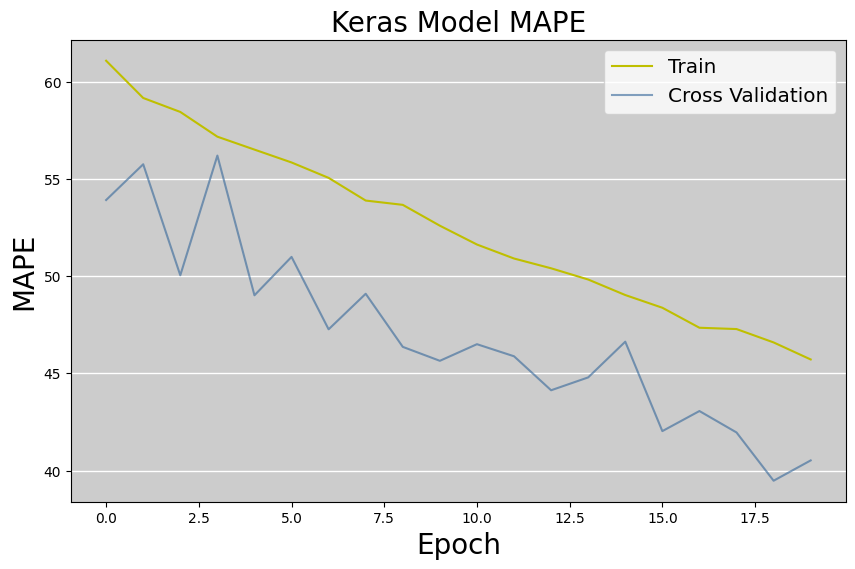

In [35]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mape'], color='y')
plt.plot(history.history['val_mape'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Keras Model MAPE',size=20)
plt.ylabel('MAPE',size=20)
plt.xlabel('Epoch',size=20)
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
plt.gca().patch.set_facecolor('0.8')
plt.legend(['Train', 'Cross Validation'],fontsize='x-large', loc='upper right')
plt.show()

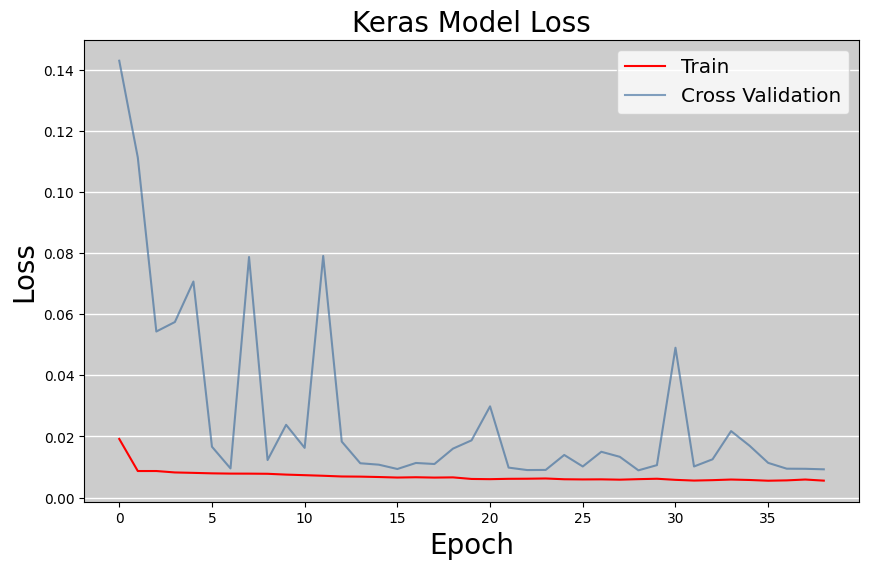

In [51]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Keras Model Loss',size=20)
plt.ylabel('Loss',size=20)
plt.xlabel('Epoch',size=20)
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
plt.gca().patch.set_facecolor('0.8')
plt.legend(['Train', 'Cross Validation'],fontsize='x-large', loc='upper right')
plt.show()

In [54]:
# Evaluate the model
train_loss, train_mse,train_mae,train_acc = model.evaluate(X_train, y_train, verbose=1)
test_loss, test_mse,test_mae,test_acc = model.evaluate(X_val, y_val, verbose=1)

773/773 [==============================] - 3s 4ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0541 - mape: 22348.4453


In [55]:
# Save the 
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_file_path = f'./files/models/model_{now}.h5py'
model.save(model_file_path)

INFO:tensorflow:Assets written to: ./files/models/model_20240712-000142.h5py\assets


INFO:tensorflow:Assets written to: ./files/models/model_20240712-000142.h5py\assets
